# Problem Statement  
MyHom is a finance company that lends housing loans at the best and most affordable interest rates to customers. In recent times, the company incurred heavy losses due to loan defaults. Most applicants failed to repay the loan as per the promissory note.
In order to avoid such losses, the company has decided to build a system for identifying the loan defaulters automatically based on data. This will help the company to identify the potential applicants and ensure the smooth running of the entire process.

Now, the company challenges the Data Science community to build a smart AI system to predict the probability of an applicant defaulting the loan or not in the future.
You are provided with the past applicant’s data containing the demographic information, loan attributes, and target variable indicating if an applicant will default the loan or not.

# Approach
Feature Engineering
* Encoding categorical data
* Missing Values
* Handling Outliers
* Normalizing with MinMaxScaler
* Feature selection
* Class Imbalance (with Weighted Logistic Regression)

Evaluting 3 models
* Simple Logistic regression
* Logistic Regression (class_weight=’balanced’)
* Logistic Regression (manual class weights)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/loan-default-prediction/sample_submission_tbPU9qQ.csv
/kaggle/input/loan-default-prediction/train_LZV4RXX.csv
/kaggle/input/loan-default-prediction/test_4zJg83n.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import data
train_r = pd.read_csv("../input/loan-default-prediction/train_LZV4RXX.csv")
test_r = pd.read_csv("../input/loan-default-prediction/test_4zJg83n.csv")
display(train_r.head(5))

,loan_id,age,education,proof_submitted,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,loan_default
0,1,27,1.0,Aadhar,504264,820920,2,2,0,0
1,2,48,1.0,Aadhar,728556,831444,6,2,0,0
2,3,30,2.0,VoterID,642936,826092,0,0,0,1
3,4,28,1.0,Aadhar,746556,930924,0,0,0,0
4,5,29,1.0,Aadhar,1139880,1902000,0,0,0,0


In [4]:
train_r.describe().round(3)

,loan_id,age,education,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,loan_default
count,7000.00,7000.000,6755.000,7000.000,7000.000,7000.000,7000.000,7000.000,7000.00
mean,3500.50,36.097,1.562,663355.173,916299.751,2.853,1.371,0.013,0.40
std,2020.87,7.588,0.496,149812.774,214492.245,5.472,2.189,0.115,0.49
min,1.00,21.000,1.000,167880.000,473352.000,0.000,0.000,0.000,0.00
25%,1750.75,29.000,1.000,577788.000,797901.000,0.000,0.000,0.000,0.00
50%,3500.50,36.000,2.000,657108.000,858426.000,0.000,0.000,0.000,0.00
75%,5250.25,43.000,2.000,737364.000,957675.000,3.000,2.000,0.000,1.00
max,7000.00,50.000,2.000,1781376.000,2419200.000,109.000,33.000,1.000,1.00


Missing Values: education  
Outliers can be in: no_of_loans,no_of_curr_loans  
categorical data: proof_submitted     

In [5]:
train_r.drop(columns=['loan_id'],inplace=True)
test_r.drop(columns=['loan_id'],inplace=True)

In [6]:
import category_encoders as ce

bin_enc = ce.BinaryEncoder()
train_oe=train_r.drop(columns=['proof_submitted'])
train_oe[['proof_submitted_0','proof_submitted_1','proof_submitted_2']] = bin_enc.fit_transform(train_r.proof_submitted)
test_oe=test_r.drop(columns=['proof_submitted'])
test_oe[['proof_submitted_0','proof_submitted_1','proof_submitted_2']]= bin_enc.transform(test_r.proof_submitted)
train_oe.head()

,age,education,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,loan_default,proof_submitted_0,proof_submitted_1,proof_submitted_2
0,27,1.0,504264,820920,2,2,0,0,0,0,1
1,48,1.0,728556,831444,6,2,0,0,0,0,1
2,30,2.0,642936,826092,0,0,0,1,0,1,0
3,28,1.0,746556,930924,0,0,0,0,0,0,1
4,29,1.0,1139880,1902000,0,0,0,0,0,0,1


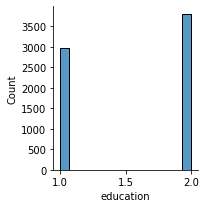

In [7]:
# Missing Values
sns.displot(train_oe.education,height=3) 

#imputation with mean
train_oe.education.fillna(train_oe.education.mean(),inplace=True )
test_oe.education.fillna(train_oe.education.mean(),inplace=True )
#train_oe.describe()

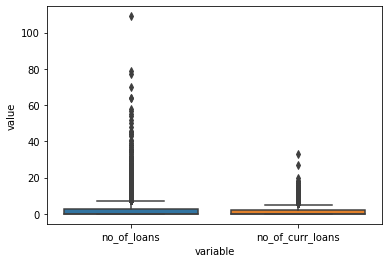

In [8]:
# Outliers
sns.boxplot(x="variable", y="value", data=pd.melt(train_oe[["no_of_loans","no_of_curr_loans"]]))
plt.show()

In [9]:
Q3 = train_oe[["no_of_loans","no_of_curr_loans"]].quantile(0.95)
print(Q3)
train_t=train_oe
test_t=test_oe
train_t.drop(train_t[train_t.no_of_loans >= 24.0 ].index, inplace=True)
train_t.drop(train_t[train_t.no_of_curr_loans >= 9.0 ].index, inplace=True)
train_t.shape

no_of_loans         12.0
no_of_curr_loans     5.0
Name: 0.95, dtype: float64


(6868, 11)

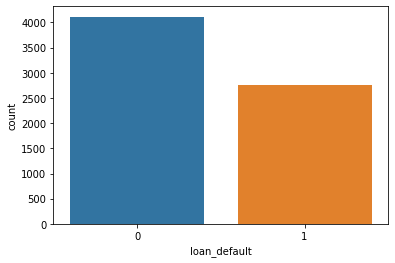

In [10]:
#Class imbalance
import seaborn as sns
sns.countplot(train_t['loan_default']);

In [11]:
print(train_t.columns)
feature_col=['age', 'education', 'loan_amount', 'asset_cost', 'no_of_loans','no_of_curr_loans', 'proof_submitted_0', 'proof_submitted_2'] #'last_delinq_none','proof_submitted_1', 

Index(['age', 'education', 'loan_amount', 'asset_cost', 'no_of_loans',
       'no_of_curr_loans', 'last_delinq_none', 'loan_default',
       'proof_submitted_0', 'proof_submitted_1', 'proof_submitted_2'],
      dtype='object')


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_t[feature_col])
scaled = scaler.fit_transform(train_t[feature_col])
train_n = pd.DataFrame(scaled, columns=train_t[feature_col].columns)

scaled_n = scaler.transform(test_t[feature_col])
test_n = pd.DataFrame(scaled_n, columns=test_t[feature_col].columns)

print(train_n.shape)
print(test_n.shape)

(6868, 8)
(3000, 8)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
x_train,x_test,y_train,y_test= train_test_split(train_n[feature_col],train_t['loan_default'],test_size=0.25,random_state=42)

In [14]:
def conf_matrix(y_test, pred_test):    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(3,3))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)

# Simple Logistic Regression

In [15]:
s_lr = LogisticRegression(solver='newton-cg')
s_lr.fit(x_train, y_train)
pred_test = s_lr.predict(x_test)
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

The f1 score for the testing data: 0.17412935323383086


              precision    recall  f1-score   support

           0       0.62      0.93      0.75      1053
           1       0.50      0.11      0.17       664

    accuracy                           0.61      1717
   macro avg       0.56      0.52      0.46      1717
weighted avg       0.58      0.61      0.53      1717



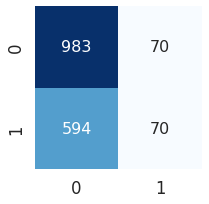

In [16]:
conf_matrix(y_test, pred_test)
print(classification_report(y_test,pred_test))

In [17]:
slr_scores = cross_val_score(s_lr, train_t[feature_col],train_t['loan_default'], cv=5)
print(slr_scores)

[0.59170306 0.59898108 0.60334789 0.59650401 0.60451566]


# Logistic Regression (class_weight=’balanced’):

In [18]:
b_lr = LogisticRegression(solver='newton-cg', class_weight='balanced')
b_lr.fit(x_train, y_train)
pred_test = b_lr.predict(x_test)
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

The f1 score for the testing data: 0.5311475409836066


              precision    recall  f1-score   support

           0       0.70      0.57      0.63      1053
           1       0.47      0.61      0.53       664

    accuracy                           0.58      1717
   macro avg       0.58      0.59      0.58      1717
weighted avg       0.61      0.58      0.59      1717



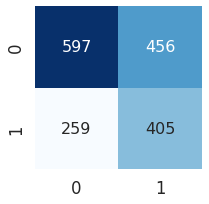

In [19]:
conf_matrix(y_test, pred_test)
print(classification_report(y_test,pred_test))

In [20]:
blr_scores = cross_val_score(b_lr, train_t[feature_col],train_t['loan_default'], cv=5)
print(blr_scores)

[0.55749636 0.56914119 0.57714702 0.55280408 0.58994902]


# Logistic Regression (manual class weights):

In [21]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
mw_lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= mw_lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1_macro', 
                          verbose=2).fit(x_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END ......................class_weight={0: 0.0, 1: 1.0}; total time=   0.1s
[CV] END class_weight={0: 0.004974874371859297, 1: 0.9950251256281407}; total time=   0.0s
[CV] END class_weight={0: 0.004974874371859297, 1: 0.9950251256281407}; total time=   0.0s
[CV] END class_weight={0: 0.009949748743718593, 1: 0.9900502512562814}; total time=   0.0s
[CV] END class_weight={0: 0.014924623115577889, 1: 0.9850753768844221}; total time=   0.0s
[CV] END class_weight={0: 0.014924623115577889, 1: 0.9850753768844221}; total time=   0.0s
[CV] END class_weight={0: 0.019899497487437186, 1: 0.9801005025125629}; total time=   0.0s
[CV] END class_weight={0: 0.024874371859296484, 1: 0.9751256281407035}; total time=   0.0s
[CV] END class_weight={0: 0.029849246231155778, 1: 0.9701507537688442}; total time=   0.0s
[CV] END class_weight={0: 0.034824120603015075, 1: 0.9651758793969849}; total time=   0.0s
[CV] END class_weight={0: 0.03979899

0.5670465730992132


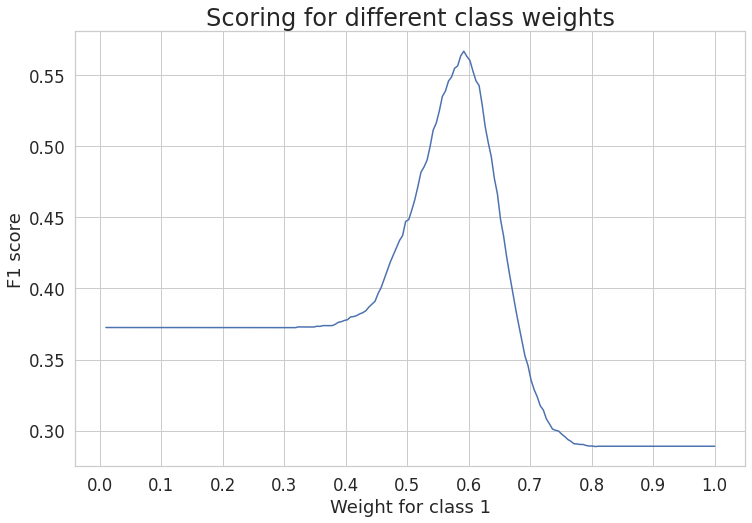

In [22]:
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)
print(weigh_data.score.max())

In [23]:
gridsearch.best_estimator_

LogisticRegression(class_weight={0: 0.4079396984924623, 1: 0.5920603015075376},
                   solver='newton-cg')

In [24]:
w_lr = LogisticRegression(solver='newton-cg', class_weight={0: 0.4079396984924623, 1: 0.5920603015075376})
w_lr.fit(x_train, y_train)
pred_test = w_lr.predict(x_test)
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

The f1 score for the testing data: 0.5139360978925901


              precision    recall  f1-score   support

           0       0.69      0.59      0.64      1053
           1       0.47      0.57      0.51       664

    accuracy                           0.58      1717
   macro avg       0.58      0.58      0.57      1717
weighted avg       0.60      0.58      0.59      1717



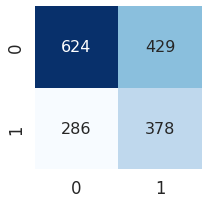

In [25]:
conf_matrix(y_test, pred_test)
print(classification_report(y_test,pred_test))

# Prediction

In [26]:
threshold=0.5

test=test_n[feature_col]
pred_t = s_lr.predict(test)
prob_test_t=w_lr.predict_proba(test) 
pred_t=np.where(prob_test_t[:,1]>threshold,1,0)